<a href="https://colab.research.google.com/github/leileihao/slc/blob/main/model_stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import os
import re
import numpy as np
import scipy.io as so
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from datetime import datetime
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.autograd import Variable
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('/content/drive/MyDrive/WeberLab')
import sleepy
import random

### Sleepy Function

In [ ]:
# Modified specifically to look at the 3_remix sleep state file
def load_stateidx(ppath, name, ann_name=''):
    """ load the sleep state file of recording (folder) $ppath/$name
    @Return:
        M,K         sequence of sleep states, sequence of
                    0'1 and 1's indicating non- and annotated states
    """
    ddir = os.path.join(ppath, name)
    ppath, name = os.path.split(ddir)

    if ann_name == '':
        ann_name = name

    remidxfile3 = os.path.join(ppath, name, '3_remidx_' + ann_name + '.txt')
    remidxfile_regular = os.path.join(ppath, name, 'remidx_' + ann_name + '.txt')

    # Check if '3_remidx_' file exists, if not use 'remidx_' file
    if os.path.exists(remidxfile3):
      remidxfile = remidxfile3
    else:
      remidxfile = remidxfile_regular


    f = open(remidxfile, 'r')
    lines = f.readlines()
    f.close()

    n = 0
    for l in lines:
        if re.match('\d', l):
            n += 1

    M = np.zeros(n, dtype='int')
    K = np.zeros(n, dtype='int')

    i = 0
    for l in lines :

        if re.search('^\s+$', l) :
            continue
        if re.search('\s*#', l) :
            continue

        if re.match('\d+\s+-?\d+', l) :
            a = re.split('\s+', l)
            M[i] = int(a[0])
            K[i] = int(a[1])
            i += 1

    return M,K


### Importing Data

In [7]:
# Concatenate the EEG, EMG, and sleep state (M) of the list of recordings
ppath = '/content/drive/MyDrive/SleepClass/Custom_Dataset_7'

recordings = os.listdir(ppath)
ndown = 4
factor = 2500 #(time bin * sampling rate)
validation_split = 0.2
EEG_test = np.array([])
EEG_train = np.array([])
EMG_test = np.array([])
EMG_train = np.array([])
M_test = np.array([])
M_train = np.array([])
False_flag = 0

for name in recordings:
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1] # cut off the end that doesn't match
  len_m = len(m)

  eeg = so.loadmat(os.path.join(ppath, name, 'EEG.mat'), squeeze_me=True)['EEG']
  eeg = eeg[:(len_m) * factor]    # truncate eeg length to the number of windows
  eeg = sleepy.downsample_vec(eeg, ndown)
  eeg = eeg.astype('float16')

  emg = so.loadmat(os.path.join(ppath, name, 'EMG.mat'), squeeze_me=True)['EMG']
  emg = emg[:(len_m) * factor]
  emg = sleepy.downsample_vec(emg, ndown)
  emg = emg.astype('float16')

  # Change all the sleep states above 3 to NREM -- can change to separate out microarousals
  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
    if m[i] == 0: # changed the unannotated segments to NREM
      m[i] = 3

  X = eeg
  Y = m
  Z = emg

  # Do the test-validation set split
  x_indices = list(range(len(X)))
  y_indices = list(range(len(Y)))
  # x_split = int(np.floor(validation_split * len(X)))
  y_split = int(np.floor(validation_split * len(Y)))
  x_split = y_split * int(factor/ndown+0.1)

  x_train_indices, x_val_indices = x_indices[x_split:], x_indices[:x_split]
  y_train_indices, y_val_indices = y_indices[y_split:], y_indices[:y_split]

  x_train = X[x_train_indices].astype('<f8')
  x_test = X[x_val_indices].astype('<f8')
  z_train = Z[x_train_indices].astype('<f8')
  z_test = Z[x_val_indices].astype('<f8')

  ## Doing normalization for each recording independently
  mean_x = np.nanmean(x_train)
  std_x = np.nanstd(x_train)

  x_train = ((x_train - mean_x) / std_x).astype('<f8')
  x_test = ((x_test - mean_x) / std_x).astype('<f8')

  mean_z = np.nanmean(z_train)
  std_z = np.nanstd(z_train)

  z_train = ((z_train - mean_z) / std_z).astype('<f8')
  z_test = ((z_test - mean_z) / std_z).astype('<f8')


  y_train = Y[y_train_indices].astype('int8')
  y_test = Y[y_val_indices].astype('int8')


  print("Loaded recording {}, eeg mean: {}, eeg std: {}, emg mean: {}, emg std: {}"
          .format(name, mean_x, std_x, mean_z, std_z))

  if (len(y_test) * 625 != len(x_test)) or (len(y_train) * 625!=len(x_train)):
    print('Length error for', name)
    False_flag = 1

  EEG_train = np.append(EEG_train, x_train)
  EMG_train = np.append(EMG_train, z_train)
  M_train = np.append(M_train, y_train)

  EEG_test = np.append(EEG_test, x_test)
  EMG_test = np.append(EMG_test, z_test)
  M_test = np.append(M_test, y_test)

assert False_flag == 0

Loaded recording J46_100918n1, eeg mean: -0.09693621252221998, eeg std: 92.7712221602342, emg mean: -0.09713032911712048, emg std: 54.74364902643321
Loaded recording J12_052818n1, eeg mean: -0.09756632244675248, eeg std: 90.7117119482564, emg mean: -0.09769658250455503, emg std: 52.898950421112964
Loaded recording c20_020618n1, eeg mean: -0.0974829969882965, eeg std: 58.803999630872745, emg mean: -0.09722581181526184, emg std: 52.670480132962005
Loaded recording J45_100918n1, eeg mean: -0.09748319424897238, eeg std: 107.63649720376205, emg mean: -0.09742848924624374, emg std: 60.96627993737547
Loaded recording J35_082118n1, eeg mean: -0.09704007222917345, eeg std: 93.5266194372923, emg mean: -0.09722458870675829, emg std: 48.76981456989392
Loaded recording c18_020418n1, eeg mean: -0.09729233593410916, eeg std: 43.51196222327882, emg mean: -0.09720869127909343, emg std: 49.475690164147714
Loaded recording c30_030418n1, eeg mean: -0.09653628292386494, eeg std: 88.5230110794834, emg mean:

### PyTorch DataLoader

In [8]:
# Combines the EEG and EMG data
X_train = np.vstack((EEG_train, EMG_train)).T
X_test = np.vstack((EEG_test, EMG_test)).T

# Upsample brain state data
y_train = np.repeat(M_train, int(factor / ndown))
y_test = np.repeat(M_test, int(factor / ndown))

In [9]:
rus = RandomUnderSampler(random_state=27)
X_train.reshape(len(M_train), -1).shape
X_restrain, M_restrain = rus.fit_resample(X_train.reshape(len(M_train), -1), M_train)   # X_train.reshape(len(M_train), -1).shape = (len(M_train), 1250)
X_restrain = X_restrain.reshape(-1, 2)
y_restrain = np.repeat(M_restrain, int(factor / ndown))

In [10]:
np.unique(M_restrain, return_counts=True)

(array([1., 2., 3.]), array([12153, 12153, 12153]))

In [11]:
class CustomDataset(Dataset):
  def __init__(self, data, labels, window_size):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.uint8)
    self.window_size = window_size

  def __len__(self):
    return len(self.data) // self.window_size

  def __getitem__(self, index):
    x = self.data[index*window_size:index*window_size+window_size][:]
    if (index*window_size >= (len(self.data) - window_size)):
        y = self.labels[index*window_size-1]
    else:
      y = self.labels[index*window_size] # so it doesn't have an out of bound

    y = y.long()

    # Perform one-hot encoding on y
    y = y - 1 # shift the labels to start at 0
    y_encoded = F.one_hot(y, num_classes = 3)

    x = x.view(-1, 2)

    return x, y_encoded

In [12]:
# Create custom datasets with normalized data
window_size = int (factor / ndown)
input_size = 2
train_dataset = CustomDataset(X_restrain, y_restrain, window_size=window_size)
test_dataset = CustomDataset(X_test, y_test, window_size=window_size)

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Define functions to be able to do normalization for each subject (mice recording) as well as taking equal number of NREM and Wake states from each mice

## Stage 1 Model Architecture

In [13]:
# Check that GPU is being used for model
torch.manual_seed(42) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.9.0+cu126
cuda:0


In [14]:
!nvidia-smi

Tue Dec  9 20:32:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
from torch import sparse
# Bidirectional LSTM
class biLSTM(nn.Module):
  def __init__(self, input_size, window_len, hidden_size=128, num_layers=2, dropout=0.2):
    super(biLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
    self.fc = nn.Sequential(
          nn.BatchNorm1d(hidden_size*2),
          nn.Linear(hidden_size*2, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, 64),
          nn.ReLU(),
          nn.Linear(64, 3), # three brain states: 1, 2, 3 (--> now 0, 1, 2 due to shift)
    )

    self.softmax = nn.Softmax(dim=1)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    batch_size, seq_len, num_channels = x.size()

    h0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)
    c0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)

    x = x.permute(0, 1, 2)  # Transpose the tensor to match the shape (batch, seq_len, num_channels)

    outl, _ = self.lstm(x, (h0, c0))
    out = outl[:, -1, :]

    out = self.fc(out)
    return out


## Stage 1 Model Training

In [16]:
print('Train set:', np.round(np.unique(y_restrain, return_counts=True)[1]/np.sum(np.unique(y_restrain, return_counts=True)[1]), 3))
print('Test set:', np.round(np.unique(y_test, return_counts=True)[1]/np.sum(np.unique(y_test, return_counts=True)[1]), 3))

Train set: [0.333 0.333 0.333]
Test set: [0.057 0.348 0.595]


In [ ]:
## Train the model

start_time = datetime.now()

num_epochs = 50
learning_rate = 0.0001

model = biLSTM(input_size=2, window_len=625, dropout=0.1).to(device).double()

loss_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_LIST = []
acc_LIST = []

val_loss_LIST = []
val_acc_LIST = []

predicted_labels = []
real_labels = []


for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    f1_scores = []
    auc_scores = []

    train_cat = np.array([0,0,0])
    test_cat = np.array([0,0,0])

    ### Training Model
    model.train()
    for iter, (input, target) in enumerate(train_loader):
        input = input.to(device).double()
        target = target.to(device).double()

        output_raw = model(input)
        loss = loss_criterion(output_raw, target)

        optimizer.zero_grad() # Reset the optimizer tensor gradient every mini-batch
        loss.backward() # Do back propagation
        optimizer.step() # Update the weight using the gradients from back propagation by learning step

        train_loss += loss.item() # Get loss and add to accumulated loss for each epoch
        train_total += target.size(0)
        output = F.one_hot(torch.max(output_raw, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
        train_correct += (torch.argmax(output, dim=1) == torch.argmax(target, dim=1)).sum().item()

        train_cat += output.cpu().numpy().sum(axis=0)
        if iter%20 == 0:
          print('Runing training output distribution in this epoch: ', np.round(train_cat/train_cat.sum(), 3))

        if epoch + 1 == num_epochs:
          output_classes = torch.argmax(output_raw, dim=1) + 1
          predicted_labels.extend(output_classes.tolist())
          target_classes = torch.argmax(target, dim=1) + 1
          real_labels.extend(target_classes.tolist())

    ### Evaluating Model
    model.eval()
    with torch.no_grad():
        for iter, (input, target) in enumerate(test_loader):
            input = input.to(device).double()
            target = target.to(device).double()

            val_output_raw = model(input)

            val_loss += loss_criterion(val_output_raw, target).item()
            val_total += target.size(0)
            val_output = F.one_hot(torch.max(val_output_raw, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
            val_correct += (torch.argmax(val_output, dim=1) == torch.argmax(target, dim=1)).sum().item()

            test_cat += val_output.cpu().numpy().sum(axis=0)
            if iter%20 == 0:
              print('Runing testing output distribution in this epoch: ', np.round(test_cat/test_cat.sum(), 3))

            # Calculate the F1 and AUC scores
            f1 = f1_score(target.cpu(), val_output.cpu(), average='macro', zero_division=0) #changed to weighted improved performance
            f1_scores.append(f1)

            auc = roc_auc_score(target.cpu().flatten(), val_output.cpu().flatten(), multi_class='ovr', average='weighted')
            auc_scores.append(auc)

            if epoch + 1 == num_epochs:
              val_output_classes = torch.argmax(val_output_raw, dim=1) + 1
              predicted_labels.extend(val_output_classes.tolist())      #### BE AWARE HERE THAT THE PREDICTED LABELS INCLUDE TRAINING RESULTS
              target_classes = torch.argmax(target, dim=1) + 1
              real_labels.extend(target_classes.tolist())

    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    avg_f1_score = sum(f1_scores) / len(f1_scores)
    avg_auc_score = sum(auc_scores) / len(auc_scores)

    loss_LIST.append(train_loss)
    acc_LIST.append(train_accuracy)

    val_loss_LIST.append(val_loss)
    val_acc_LIST.append(val_accuracy)

    print("Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%, F1 Score: {:.4f}, AUC Score: {:.4f}"
          .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, avg_f1_score, avg_auc_score))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:
## Save classification model as a pickle file
import pickle

pick_insert = open('drive/My Drive/MultiVanillaModelPart1N.pkl','wb')
pickle.dump(model, pick_insert)
pick_insert.close()

In [18]:
## show model specifications

model

biLSTM(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
)

### Visualizations

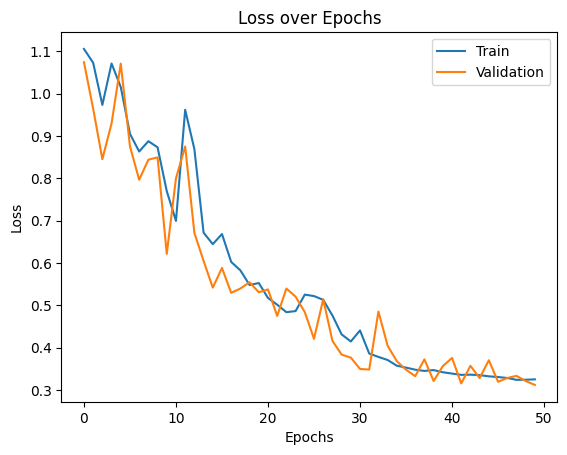

In [ ]:
fig0, ax0 = plt.subplots()
ax0.plot(loss_LIST, label = 'Train')
ax0.plot(val_loss_LIST, label = 'Validation')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

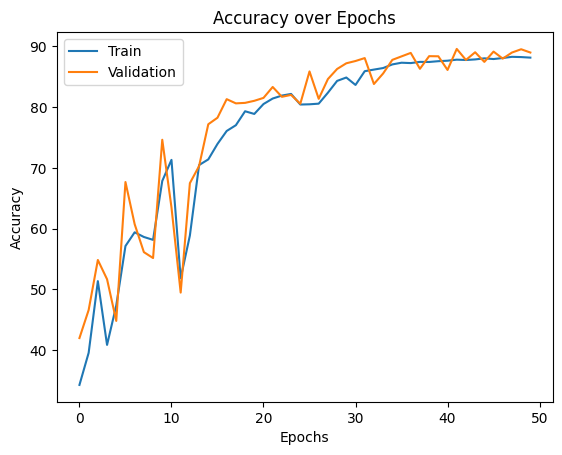

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(acc_LIST, label = 'Train')
ax1.plot(val_acc_LIST, label = 'Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Stage 1 Model Evaluating

In [19]:
random.seed(46)

In [ ]:
import io
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

biLSTM_model = CPU_Unpickler(open('MultiVanillaModelPart1N.pkl',"rb")).load()

In [ ]:
# Concatenate the EEG, EMG, and sleep state (M) of the list of recordings
ppath = '/content/drive/MyDrive/SleepClass/Custom_Dataset_7'

recordings = os.listdir(ppath)
ndown = 4
factor = 2500 #(time bin * sampling rate)
validation_split = 0.2
EEG_test = np.array([])
EEG_train = np.array([])
EMG_test = np.array([])
EMG_train = np.array([])
M_test = np.array([])
M_train = np.array([])
False_flag = 0

for name in recordings:
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1] # cut off the end that doesn't match
  len_m = len(m)

  eeg = so.loadmat(os.path.join(ppath, name, 'EEG.mat'), squeeze_me=True)['EEG']
  eeg = eeg[:(len_m) * factor]    # truncate eeg length to the number of windows
  eeg = sleepy.downsample_vec(eeg, ndown)
  eeg = eeg.astype('float16')

  emg = so.loadmat(os.path.join(ppath, name, 'EMG.mat'), squeeze_me=True)['EMG']
  emg = emg[:(len_m) * factor]
  emg = sleepy.downsample_vec(emg, ndown)
  emg = emg.astype('float16')

  # Change all the sleep states above 3 to NREM -- can change to separate out microarousals
  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
    if m[i] == 0: # changed the unannotated segments to NREM
      m[i] = 3

  X = eeg
  Y = m
  Z = emg

  # Do the test-validation set split
  x_indices = list(range(len(X)))
  y_indices = list(range(len(Y)))
  # x_split = int(np.floor(validation_split * len(X)))
  y_split = int(np.floor(validation_split * len(Y)))
  x_split = y_split * int(factor/ndown+0.1)

  x_train_indices, x_val_indices = x_indices[x_split:], x_indices[:x_split]
  y_train_indices, y_val_indices = y_indices[y_split:], y_indices[:y_split]

  x_train = X[x_train_indices]
  x_test = X[x_val_indices]

  z_train = Z[x_train_indices]
  z_test = Z[x_val_indices]

  y_train = Y[y_train_indices]
  y_test = Y[y_val_indices]

  if (len(y_test) * 625 != len(x_test)) or (len(y_train) * 625!=len(x_train)):
    print('Length error for', name)
    False_flag = 1

  EEG_train = np.append(EEG_train, x_train)
  EMG_train = np.append(EMG_train, z_train)
  M_train = np.append(M_train, y_train)

  EEG_test = np.append(EEG_test, x_test)
  EMG_test = np.append(EMG_test, z_test)
  M_test = np.append(M_test, y_test)

assert False_flag == 0

recordings

['c19_020418n1',
 'J9_052318n1',
 'J35_082118n1',
 'J12_052818n1',
 'J45_100918n1',
 'c30_030418n1',
 'c20_020618n1',
 'c18_020418n1',
 'AC81_081221n1',
 'AC85_082321n1',
 'c36_032518n1',
 'J17_062618n1']

In [ ]:
# Combines the EEG and EMG data
X_train = np.vstack((EEG_train, EMG_train)).T
X_test = np.vstack((EEG_test, EMG_test)).T

# Upsample brain state data
y_train = np.repeat(M_train, int(factor / ndown))
y_test = np.repeat(M_test, int(factor / ndown))


from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=27)
X_train.reshape(len(M_train), -1).shape
X_restrain, M_restrain = rus.fit_resample(X_train.reshape(len(M_train), -1), M_train)   # X_train.reshape(len(M_train), -1).shape = (len(M_train), 1250)
X_restrain = X_restrain.reshape(-1, 2)
y_restrain = np.repeat(M_restrain, int(factor / ndown))

from sklearn.preprocessing import StandardScaler
X_restrain = StandardScaler().fit_transform(X_restrain)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
# Create custom datasets with normalized data
window_size = int (factor / ndown)
input_size = 2
train_dataset = CustomDataset(X_restrain, y_restrain, window_size=window_size)
test_dataset = CustomDataset(X_test, y_test, window_size=window_size)

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
val_loss = 0.0
val_correct = 0
val_total = 0
loss_criterion = nn.CrossEntropyLoss()
predicted_labels = []
real_labels = []

biLSTM_model.eval()
for iter, (input, target) in enumerate(test_loader):
    input = input.to(device).double()
    target = target.to(device).double()

    val_output_raw = biLSTM_model(input)

    val_total += target.size(0)
    val_output = F.one_hot(torch.max(val_output_raw, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
    val_correct += (torch.argmax(val_output, dim=1) == torch.argmax(target, dim=1)).sum().item()

    val_output_classes = torch.argmax(val_output_raw, dim=1) + 1
    predicted_labels.extend(val_output_classes.tolist())      #### BE AWARE HERE THAT THE PREDICTED LABELS INCLUDE TRAINING RESULTS
    target_classes = torch.argmax(target, dim=1) + 1
    real_labels.extend(target_classes.tolist())

val_accuracy = 100 * val_correct / val_total


print(val_accuracy)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


89.54174866460501


In [ ]:
predicted_labels

[2,
 3,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 1,
 3,
 3,
 3,
 2,
 1,
 3,
 3,
 2,
 3,
 3,
 1,
 1,
 2,
 1,
 2,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 2,
 3,
 1,
 2,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 1,
 3,
 3,
 1,
 3,
 2,
 1,
 3,
 3,
 3,
 2,
 2,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 1,
 1,
 3,
 1,
 2,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 3,
 3,
 2,
 3,
 1,
 2,
 1,
 1,
 3,
 1,
 3,
 2,
 2,
 3,
 1,
 1,
 2,
 3,
 3,
 2,
 2,
 3,
 1,
 2,
 1,
 3,
 2,
 1,
 3,
 3,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 2,
 3,
 2,
 1,
 3,
 2,
 1,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 1,
 3,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 3,
 3,
 2,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 1,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 1,
 1,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 2,
 1,
 2,
 2,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
